In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
df = pd.read_pickle("../data/df.pickle")
df = df.dropna()

In [3]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_resi1 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-01")].dropna()
df_resi2 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-11-16")].dropna()
df_2020_nov = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-12-01")].dropna()
df_lockdown_relax = df[(df["started_at"] >= "2020-11-16") & (df["started_at"] < "2020-12-17")].dropna()
df_after_lockdown = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2023-10-01")].dropna()
df_aft_eto = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-02-23")].dropna()

# dfを2ヶ月ごとに分割
df_2020_4_5 = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] < "2020-06-01")].dropna()
df_2020_6_7 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-08-01")].dropna()
df_2020_8_9 = df[(df["started_at"] >= "2020-08-01") & (df["started_at"] < "2020-10-01")].dropna()
df_2020_10_11 = df[(df["started_at"] >= "2020-10-01") & (df["started_at"] < "2020-12-01")].dropna()
df_2020_12 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] < "2021-01-01")].dropna()

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

In [5]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [6]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='start_station_name')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        # start_station_nameをリスト化
        df_tmp['start_station_id'] = df_tmp['start_station_id'].astype(float)
        df_tmp['end_station_id'] = pd.to_numeric(df_tmp['end_station_id'], errors='coerce')

        station_df = df_tmp[['start_station_id', 'start_station_name']].drop_duplicates()
        station_df = station_df.set_index('start_station_id')

        # node_listにstation_dfの数を追加
        node_list.append(len(station_df))

        # edge_listにdf_tmpの数を追加
        edge_list.append(len(df_tmp))   
        
        current_timestamp = next_timestamp


    # node_listとedge_listで0の値を削除
    
    return node_list, edge_list, timestamp

In [7]:
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [8]:
alpha_list = [0.471, 0.352, 0.081, 0.447, 0.205, 0.115, 0.116]
beta_list = [9.707, 5.342, 0.819, 25.649, 4.351, 8.175, 7.791]
label_list = ["Lockdown", "2020/6/1~2020/10/31", "2020/11/1~2020/11/30", "2020/12/1~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

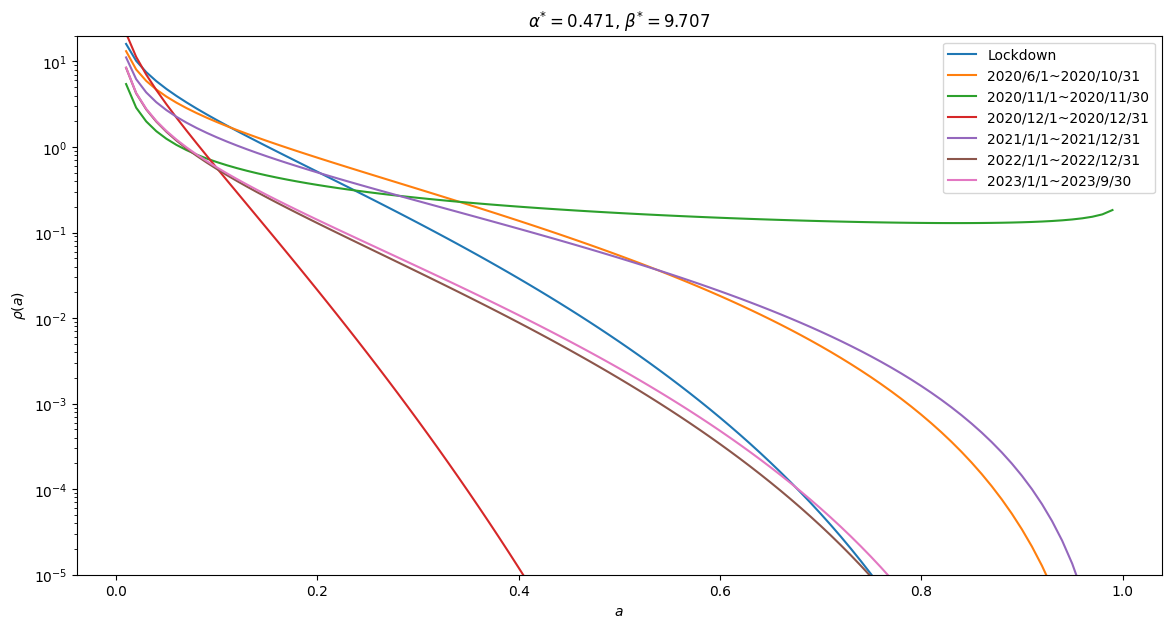

In [91]:
a = np.arange(0, 1, 0.01)
plt.figure(figsize=(14,7))
plt.plot(a, rho(a, alpha_list[0], beta_list[0]), label=label_list[0])
plt.plot(a, rho(a, alpha_list[1], beta_list[1]), label=label_list[1])
plt.plot(a, rho(a, alpha_list[2], beta_list[2]), label=label_list[2])
plt.plot(a, rho(a, alpha_list[3], beta_list[3]), label=label_list[3])
plt.plot(a, rho(a, alpha_list[4], beta_list[4]), label=label_list[4])
plt.plot(a, rho(a, alpha_list[5], beta_list[5]), label=label_list[5])
plt.plot(a, rho(a, alpha_list[6], beta_list[6]), label=label_list[6])


plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
plt.yscale("log")
plt.ylim(10**(-5), 20)
plt.title(r"$\alpha^{*}=$"+str(round(alpha_list[0], 3))+r", $\beta^{*}=$"+str(round(beta_list[0], 3)))
plt.legend()
plt.show()

In [13]:
a = np.arange(0, 1, 0.01)
rho_list = []
for i in range(len(a)):
    # 1.0 - betainc(alpha, beta, a) = betainc(beta, alpha, 1-a)
    rho_list.append(special.betainc(alpha_list[0], beta_list[0], 1 - a[i]))

rho_list2 = []
for i in range(len(a)):
    rho_list2.append(special.betainc(alpha_list[1], beta_list[1], 1 - a[i]))
    

rho_list3 = []
for i in range(len(a)):
    rho_list3.append(special.betainc(alpha_list[2], beta_list[2], 1 - a[i]))
    

rho_list4 = []
for i in range(len(a)):
    rho_list4.append(special.betainc(alpha_list[3], beta_list[3], 1 - a[i]))
    

rho_list5 = []
for i in range(len(a)):
    rho_list5.append(special.betainc(alpha_list[4], beta_list[4], 1 - a[i]))
    

rho_list6 = []
for i in range(len(a)):
    rho_list6.append(special.betainc(alpha_list[5], beta_list[5], 1 - a[i]))
    

rho_list7 = []
for i in range(len(a)):
    rho_list7.append(special.betainc(alpha_list[6], beta_list[6], 1 - a[i]))
    

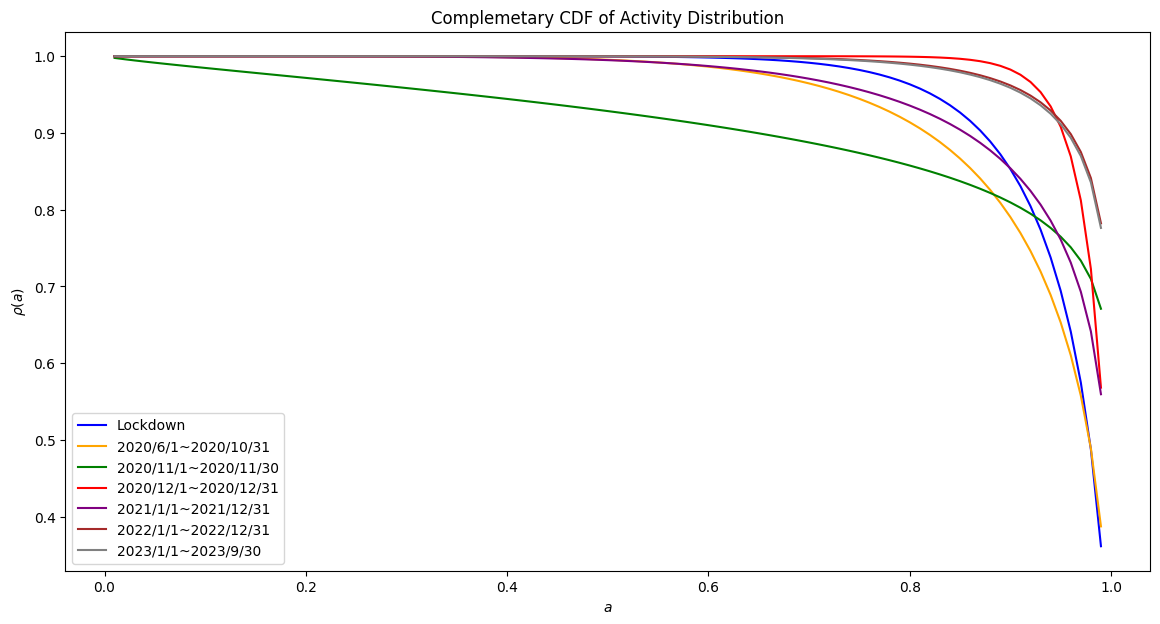

In [14]:
plt.figure(figsize=(14,7))
plt.plot(a[1:], rho_list[1:], label=label_list[0], color="blue")
plt.plot(a[1:], rho_list2[1:], label=label_list[1], color="orange")
plt.plot(a[1:], rho_list3[1:], label=label_list[2], color="green")
plt.plot(a[1:], rho_list4[1:], label=label_list[3], color="red")
plt.plot(a[1:], rho_list5[1:], label=label_list[4], color="purple")
plt.plot(a[1:], rho_list6[1:], label=label_list[5], color="brown")
plt.plot(a[1:], rho_list7[1:], label=label_list[6], color="gray")


plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
#plt.yscale("log")
#plt.ylim(10**(-5), 20)
plt.title(r"Complemetary CDF of Activity Distribution")
plt.legend()
plt.show()

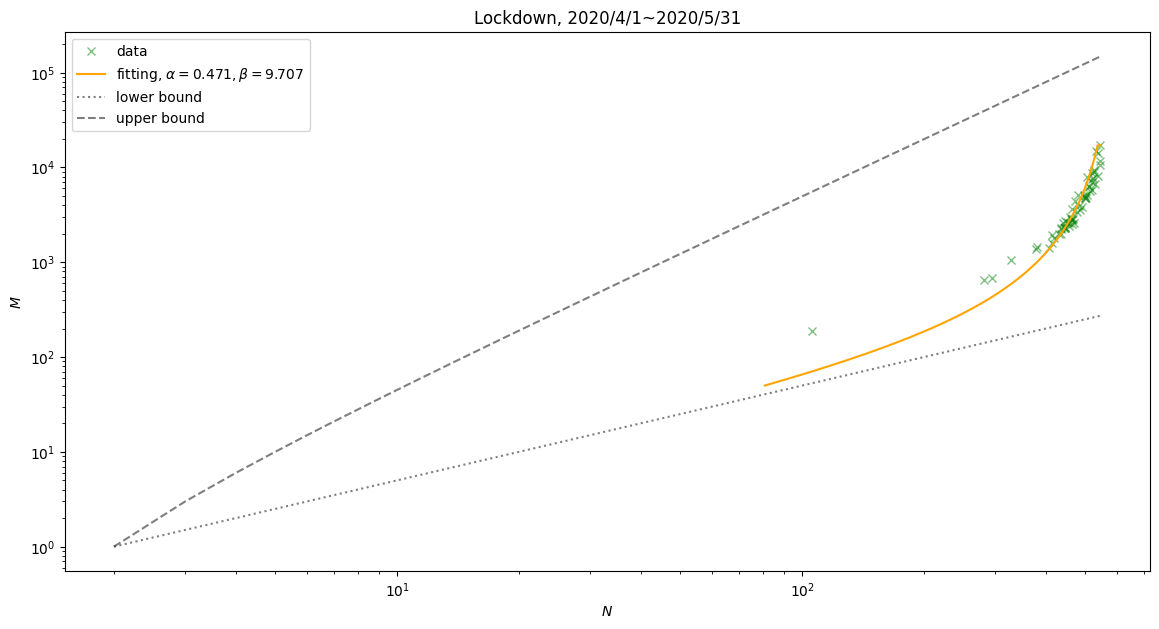

In [57]:
node, edge = return_nm(df_lockdown)

plt.figure(figsize=(14,7))

N = node
M = edge
Np = 596 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(50, np.max(M))


plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("Lockdown, 2020/4/1~2020/5/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

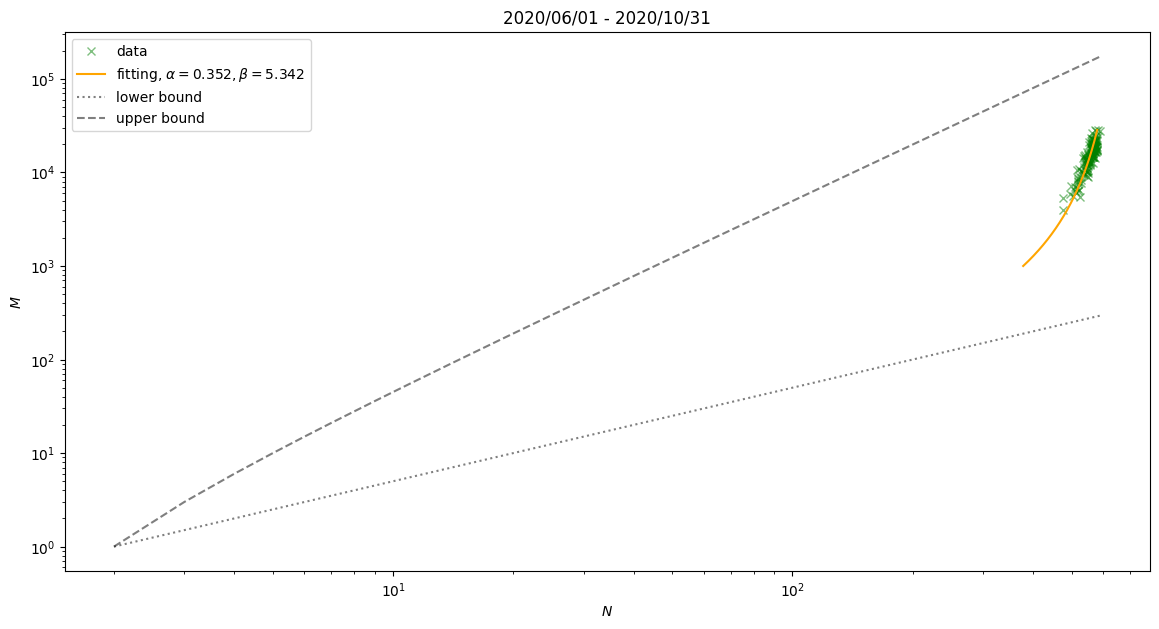

In [60]:
node, edge = return_nm(df_resi1)

plt.figure(figsize=(14,7))

N = node
M = edge
Np = 673 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(1000, np.max(M))


plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/06/01 - 2020/10/31")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

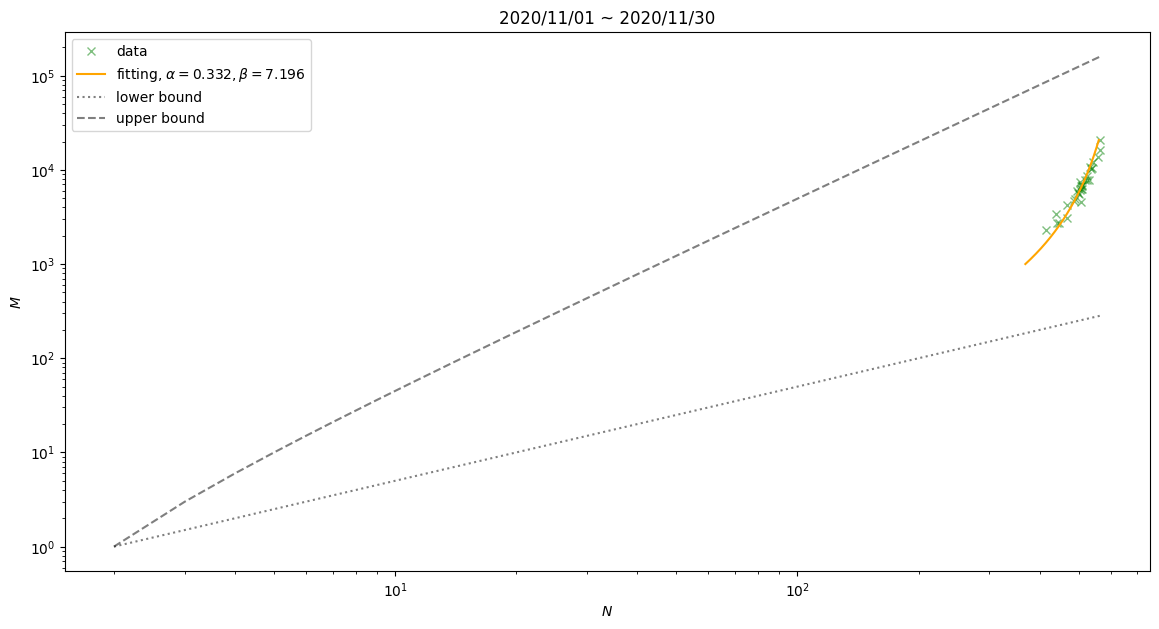

In [63]:
node, edge = return_nm(df_2020_nov)

plt.figure(figsize=(14,7))

N = node
M = edge
Np = 677 # histrical dataから求めたNp

x = np.arange(2, np.max(N))
y = np.arange(1000, np.max(M))


plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/11/01 ~ 2020/11/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

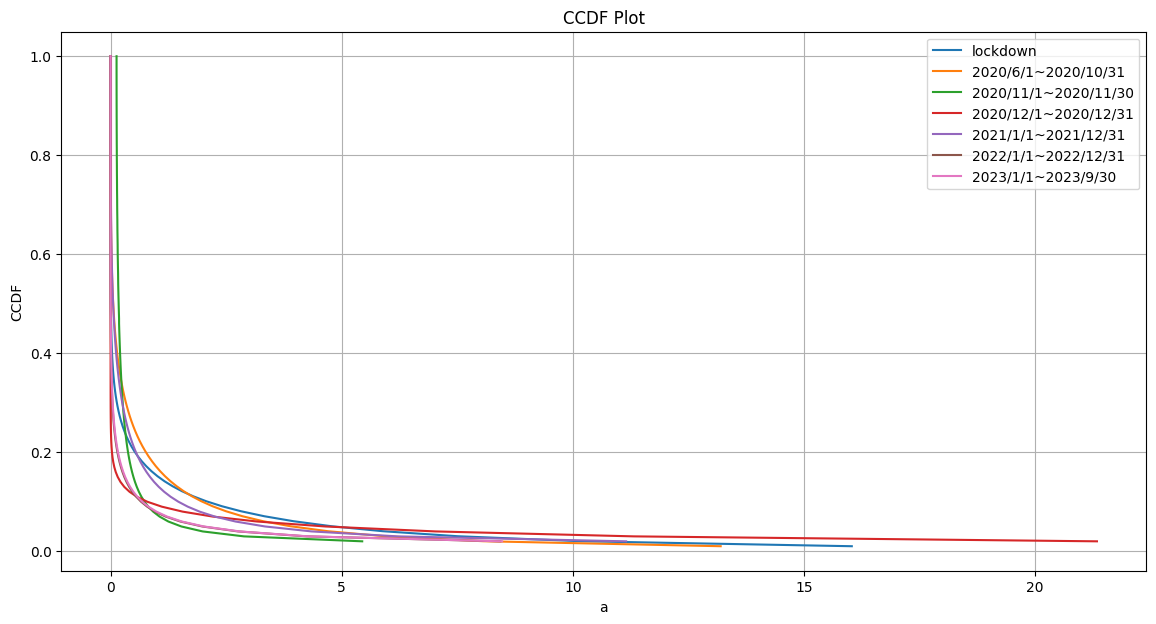

In [87]:
# CCDF
# データのソートとCCDFの計算
a = np.arange(0, 1, 0.01)
rho_list = []
for i in range(len(a)):
    rho_list.append(rho(a[i], alpha_list[0], beta_list[0]))
sorted_data = np.sort(rho_list)
ccdf = 1.0 - np.arange(len(sorted_data)) / float(len(sorted_data) - 1)

rho_list2 = []
for i in range(len(a)):
    rho_list2.append(rho(a[i], alpha_list[1], beta_list[1]))
sorted_data2 = np.sort(rho_list2)
ccdf2 = 1.0 - np.arange(len(sorted_data2)) / float(len(sorted_data2) - 1)

rho_list3 = []
for i in range(len(a)):
    rho_list3.append(rho(a[i], alpha_list[2], beta_list[2]))
sorted_data3 = np.sort(rho_list3)
ccdf3 = 1.0 - np.arange(len(sorted_data3)) / float(len(sorted_data3))

rho_list4 = []
for i in range(len(a)):
    rho_list4.append(rho(a[i], alpha_list[3], beta_list[3]))
sorted_data4 = np.sort(rho_list4)
ccdf4 = 1.0 - np.arange(len(sorted_data4)) / float(len(sorted_data4))

rho_list5 = []
for i in range(len(a)):
    rho_list5.append(rho(a[i], alpha_list[4], beta_list[4]))
sorted_data5 = np.sort(rho_list5)
ccdf5 = 1.0 - np.arange(len(sorted_data5)) / float(len(sorted_data5))

rho_list6 = []
for i in range(len(a)):
    # 積分する
    rho_list6.append(rho(a[i], alpha_list[5], beta_list[5]))
sorted_data6 = np.sort(rho_list6)
ccdf6 = 1.0 - np.arange(len(sorted_data6)) / float(len(sorted_data6))

rho_list7 = []
for i in range(len(a)):
    rho_list7.append(rho(a[i], alpha_list[6], beta_list[6]))
sorted_data7 = np.sort(rho_list7)
ccdf7 = 1.0 - np.arange(len(sorted_data7)) / float(len(sorted_data7))


# プロット
plt.figure(figsize=(14,7))
plt.plot(sorted_data, ccdf, label="lockdown", linestyle="solid")
plt.plot(sorted_data2, ccdf2, label="2020/6/1~2020/10/31", linestyle="solid")
plt.plot(sorted_data3, ccdf3, label="2020/11/1~2020/11/30", linestyle="solid")
plt.plot(sorted_data4, ccdf4, label="2020/12/1~2020/12/31", linestyle="solid")
plt.plot(sorted_data5, ccdf5, label="2021/1/1~2021/12/31", linestyle="solid")
plt.plot(sorted_data6, ccdf6, label="2022/1/1~2022/12/31", linestyle="solid")
plt.plot(sorted_data7, ccdf7, label="2023/1/1~2023/9/30", linestyle="solid")
# plt.xscale('log')  # 対数スケールにする場合（任意）
# plt.yscale('log')  # 対数スケールにする場合（任意）
plt.xlabel('a')
plt.ylabel('CCDF')
plt.title('CCDF Plot')
plt.grid(True)
plt.legend()
plt.show()


In [116]:
# kappaの計算
def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

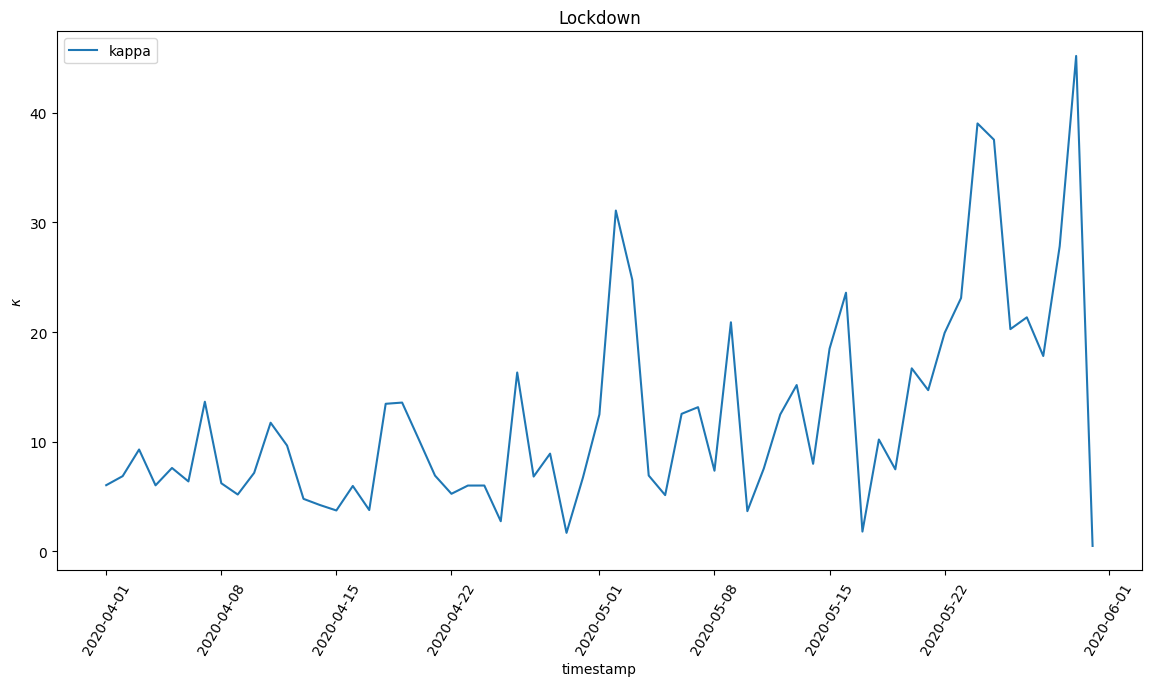

In [128]:
node, edge, timestamp = return_nm(df_lockdown)

N = node
M = edge
Np = 596 # histrical dataから求めたNp


params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

kappa_list = []
for i in range(len(M)):
    kappa_list.append(kappa(M[i], Np))
  
plt.figure(figsize=(14,7))
plt.plot(timestamp, kappa_list, label="kappa")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel(r"$\kappa$")
plt.title("Lockdown")
plt.legend()
plt.show()


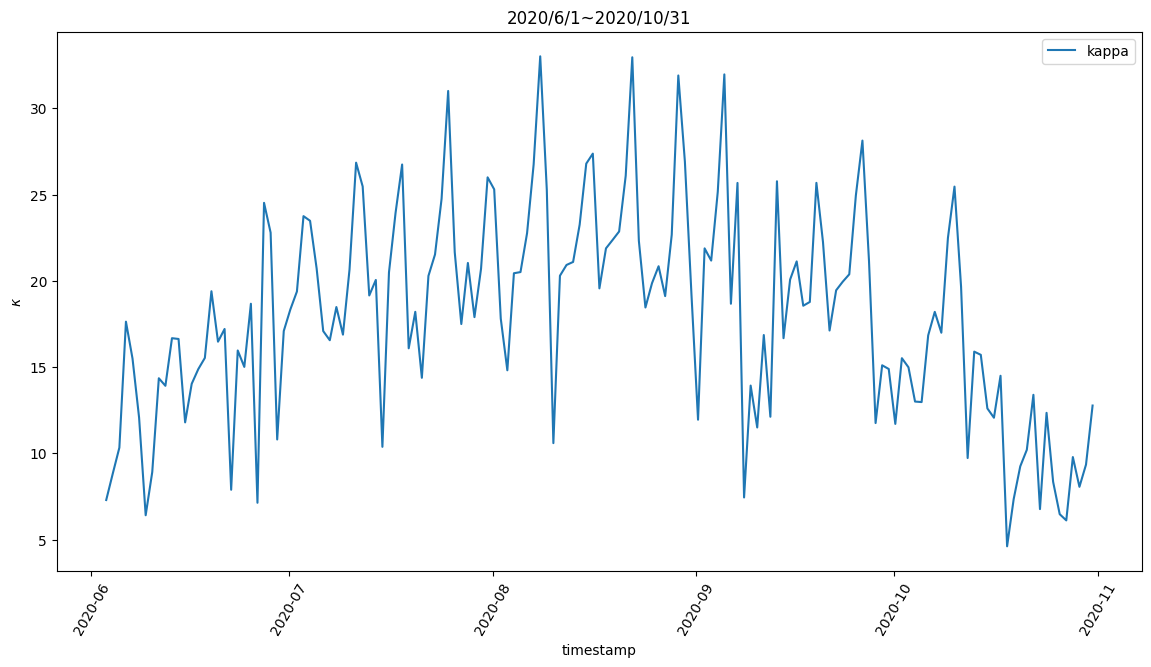

In [127]:
node, edge, timestamp = return_nm(df_resi1)

N = node
M = edge
Np = 673 # histrical dataから求めたNp


params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[1, 1])
alpha = params[0]
beta = params[1]

kappa_list = []
for i in range(len(M)):
    kappa_list.append(kappa(M[i], Np))
  
plt.figure(figsize=(14,7))
plt.plot(timestamp, kappa_list, label="kappa")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel(r"$\kappa$")
plt.title("2020/6/1~2020/10/31")
plt.legend()
plt.show()


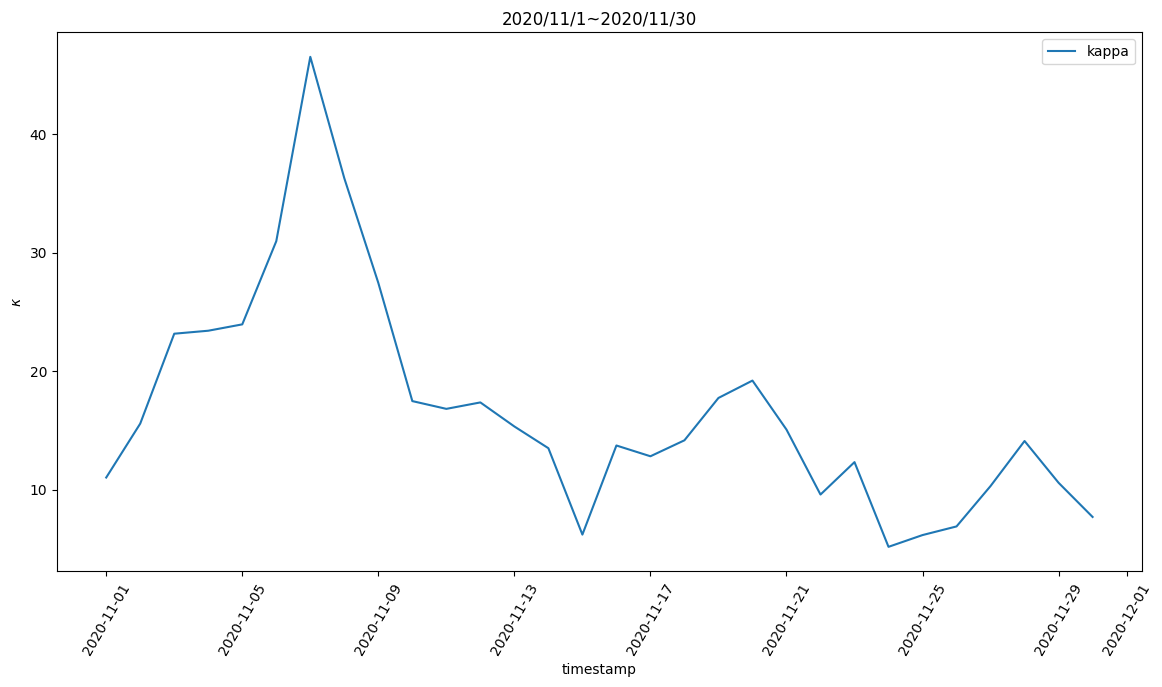

In [124]:
node, edge, timestamp = return_nm(df_2020_nov)

N = node
M = edge
Np = 677 # histrical dataから求めたNp


params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[1, 1])
alpha = params[0]
beta = params[1]

kappa_list = []
for i in range(len(M)):
    kappa_list.append(kappa(M[i], Np))
  
plt.figure(figsize=(14,7))
plt.plot(timestamp, kappa_list, label="kappa")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel(r"$\kappa$")
plt.title("2020/11/1~2020/11/30")
plt.legend()
plt.show()


In [129]:
# dfを2ヶ月ごとに分割
df_2020_4_5 = df[(df["started_at"] >= "2020-04-01") & (df["started_at"] < "2020-06-01")].dropna()
df_2020_6_7 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-08-01")].dropna()
df_2020_8_9 = df[(df["started_at"] >= "2020-08-01") & (df["started_at"] < "2020-10-01")].dropna()
df_2020_10_11 = df[(df["started_at"] >= "2020-10-01") & (df["started_at"] < "2020-12-01")].dropna()
df_2020_12 = df[(df["started_at"] >= "2020-12-01") & (df["started_at"] < "2021-01-01")].dropna()

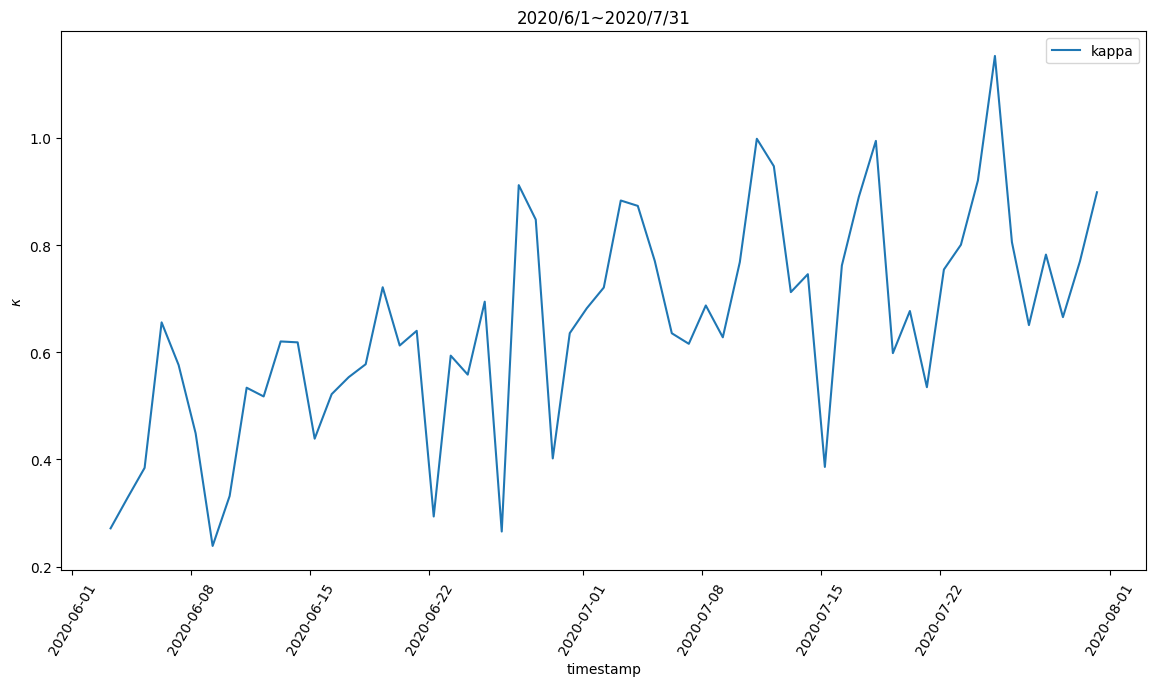

In [132]:
node, edge, timestamp = return_nm(df_2020_6_7)
N = node
M = edge
Np = 673 # histrical dataから求めたNp


params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[1, 1])
alpha = params[0]
beta = params[1]

kappa_list = []
for i in range(len(M)):
    kappa_list.append(kappa(M[i], Np))
  
plt.figure(figsize=(14,7))
plt.plot(timestamp, kappa_list, label="kappa")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel(r"$\kappa$")
plt.title("2020/6/1~2020/7/31")
plt.legend()
plt.show()

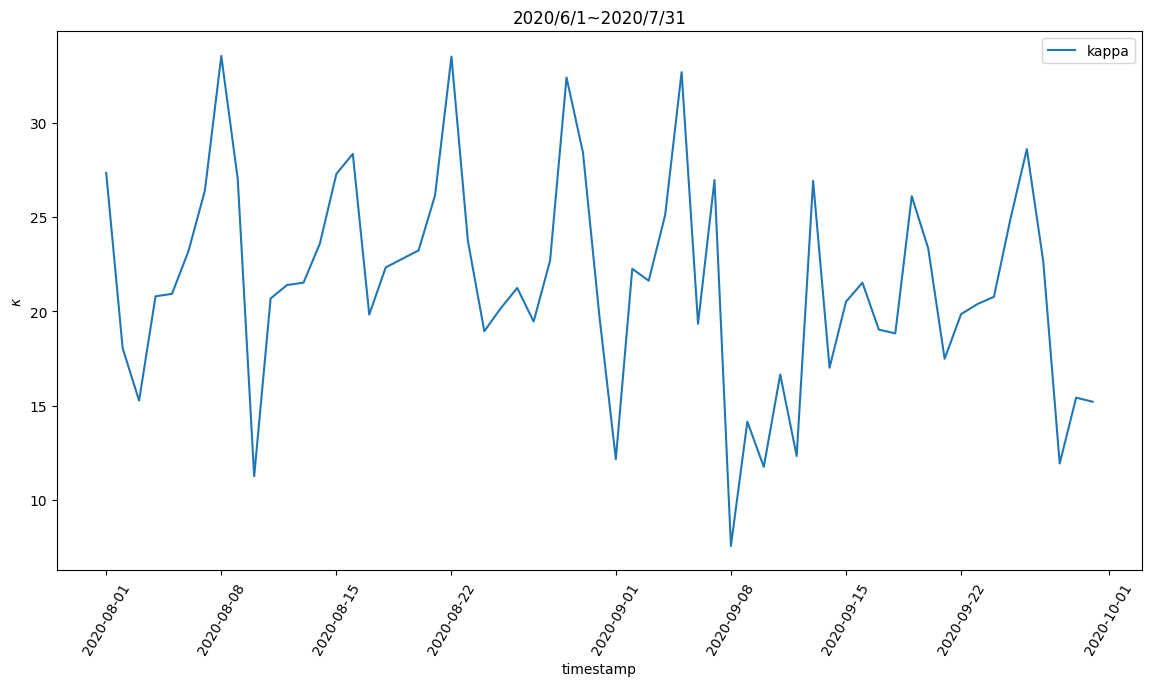

In [133]:
node, edge, timestamp = return_nm(df_2020_8_9)
N = node
M = edge
Np = 673 # histrical dataから求めたNp


params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[1, 1])
alpha = params[0]
beta = params[1]

kappa_list = []
for i in range(len(M)):
    kappa_list.append(kappa(M[i], Np))
  
plt.figure(figsize=(14,7))
plt.plot(timestamp, kappa_list, label="kappa")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel(r"$\kappa$")
plt.title("2020/7/1~2020/9/30")
plt.legend()
plt.show()